<a href="https://colab.research.google.com/github/vdnghia03/Deep-Learning/blob/main/DL6_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## Recurrent neural networks (RNN)
---

Read more:
- [RNN - wikipedia](https://en.wikipedia.org/wiki/Recurrent_neural_network)
- [LSTM - wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)
- [LSTM - Colah (2015) blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Time series forecasting - Brownlee (2016) machinelearningmastery](https://machinelearningmastery.com/time-series-forecasting/)
- [TimeSeriesGenerator - Brownlee (2016) machinelearningmastery](https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/)


---
### Simulte time series
Time series are usually represented as 3D tensor(batch_size, time_steps, dimensionality). Dimensions is 1 for univariate time series.

<Axes: title={'center': 'Times series: $0.5 \\sin{2t} + 2 \\cos{0.5t}$'}, xlabel='Time units', ylabel='Sales'>

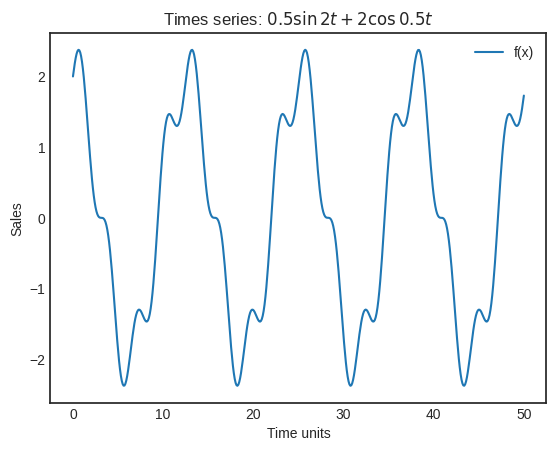

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-white")

f = lambda t: 0.5 * np.sin(2*t) + 2 * np.cos(0.5*t)

x = np.linspace(0,50,500)
df =pd.DataFrame(f(x), index=x, columns = ["f(x)"])

df.plot(
    title = r"Times series: $0.5 \sin{2t} + 2 \cos{0.5t}$"
    , ylabel = "Sales"
    , xlabel = "Time units"
)

---
### Train|test split

For timeseries we split the first section as training and the rest as test, as it is the test part that we are interested in predicting which is the "future" in the perspective of training data. The idea is analogous for train|validation|test split

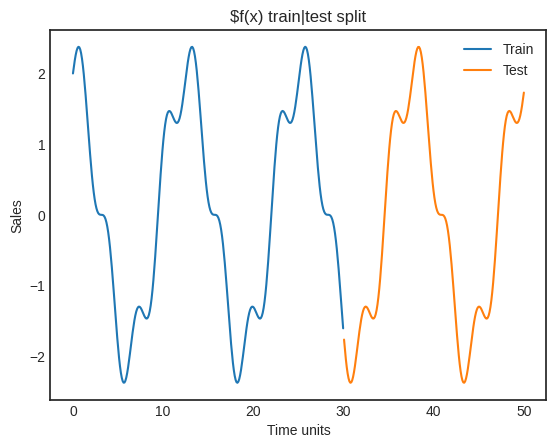

In [32]:
test_split = 200
df_train = df.iloc[:-test_split]
df_test  = df.iloc[-test_split:]

ax = plt.axes()
df_train.plot(
    ax = ax
    , title = r"$f(x) train|test split"
    , ylabel = "Sales"
    , xlabel = "Time units"
)

df_test.plot(ax=ax)
ax.legend(["Train", "Test"])

### Scale data

RNN uses backpropagation through time (BPTT) to calculate gradients for an optimization algorithm to adjust the weights to minimize a loss function. Hence, the data need to be scaled before using in order for it to learn properly.

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

print(f"{scaled_train.shape=}, {scaled_test.shape=}")

scaled_test.min(), scaled_test.max()



scaled_train.shape=(300, 1), scaled_test.shape=(200, 1)


(np.float64(0.00011292154516773234), np.float64(0.9994100860551354))

---
### Generate time series batches

We need to generate time series batches of the form (batch_size, time_steps, dimensionality) as input to RNN

Before we generate batches we need to determine the batch length. You should pick a batch length that captures the seasonality (periodicity), but is smaller than the test data.


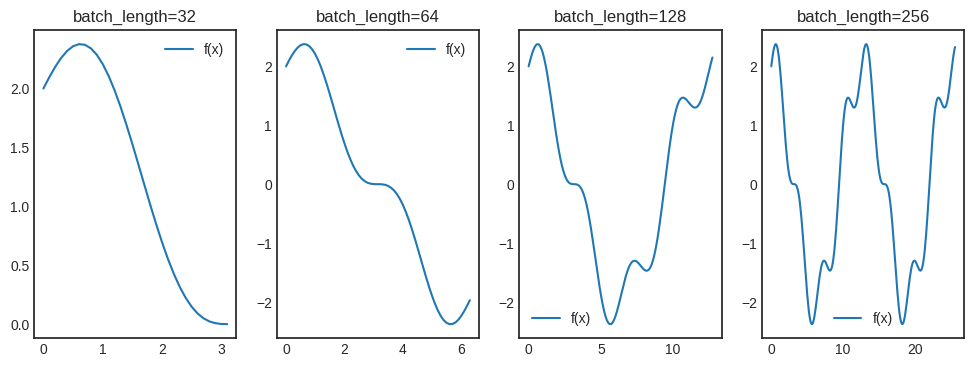

In [34]:
batch_lengths = [32,64,128,256]
fig, axes = plt.subplots(1,4, figsize=(12,4))

for batch_length, ax in zip(batch_lengths, axes):
  df_train.iloc[:batch_length].plot(ax=ax)
  ax.set_title(f"{batch_length=}")

-> Nhìn vào ta thấy nên chọn batch_size = 128 vì nó giữ được chu kì tốt. Không chọn 256 vì vượt quá test size

In [35]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# (batch_size, batch_length, dimension)

batch_length = 128 # how much data points as input for predciting next output
batch_size = 1 # how large the predicted output should be as 1 batch givesone output

train_generator = TimeseriesGenerator(
    scaled_train, scaled_train, length=batch_length, batch_size = batch_size
) # scaled_train -> 2D will to train_generator -> 3D
test_generator = TimeseriesGenerator(
    scaled_test, scaled_test, length=batch_length, batch_size = batch_size
)

X, y = train_generator[0]
print(f"{X.shape=}, {y.shape=}")


X.shape=(1, 128, 1), y.shape=(1, 1)


In [36]:
X[0, -5:, 0], scaled_train[batch_length-5:batch_length].flatten()

(array([0.8686539 , 0.89018132, 0.91183131, 0.93277341, 0.95216592]),
 array([0.8686539 , 0.89018132, 0.91183131, 0.93277341, 0.95216592]))

In [37]:

print("Next value to be predicted")
y, scaled_train[batch_length]

Next value to be predicted


(array([[0.96918959]]), array([0.96918959]))

In [38]:
len(scaled_test)

200

In [39]:
len(train_generator)


172

In [40]:
len(test_generator)

72

---
### RNN

RNN has a short-term dependancy as it is processing a sequence. The state of the current unit is provided as input together with next element in a squence to the next unit. It is these hidden states *h1, ... , ht* that gives the RNN its memories

Problems with RNN are:

- exploding gradients
- vanishing gradients
- can't process longer sequences well

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def RNN_model(RNN_layers: "Sequential"):
  model = Sequential(name = "RNN")
  model.add(RNN_layers)
  model.add(Dense(1))
  model.compile(optimizer="adam", loss = "mse")
  return model


RNN_layers = SimpleRNN(units = batch_length, return_sequences=False , input_shape = (None, 1))

model = RNN_model(RNN_layers)
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0913 - val_loss: 0.0058
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0039 - val_loss: 3.5349e-04
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 6.9096e-04
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6991e-04 - val_loss: 8.6048e-05


<Axes: >

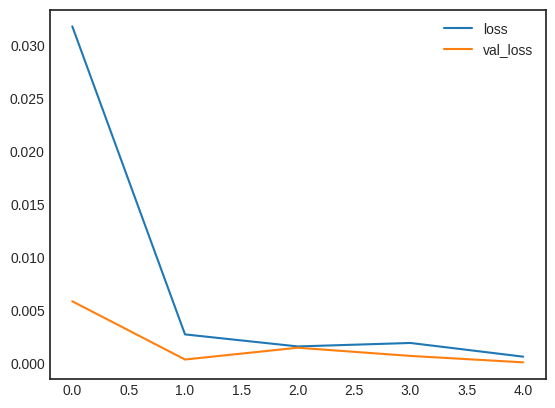

In [43]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot()

### Predictions

As the network predicts one value at a time with the setting we have chosen, we need to loop and create new batches of data so that it properly predicts next value in the time series

- input shape is (batch_size, batch_length, feature)
- output shape is (batch_size, feature)

In [44]:

predictions = np.zeros([len(scaled_test),1])
# picks out last data points in training data as first batch
first_batch = scaled_train[-batch_length:]
print(f"{first_batch.shape=}")
# need shape (batch_size, batch_length, dimensions)
new_batch = first_batch[None, :] # Because input shape is (batch_size, batch_length, dimension)
print(f"{new_batch.shape=}")

for i in range(len(scaled_test)):
  new_pred = model.predict(new_batch) # shape (1,1) Because out is (batch_size, 1)
  predictions[i] = new_pred[0]
  # rolling prediction
  new_batch = np.append(new_batch[:, 1:, :], [new_pred], axis = 1)

y_pred = scaler.inverse_transform(predictions)

y_pred.shape

y_pred[:3], df_test.iloc[:3].values

first_batch.shape=(128, 1)
new_batch.shape=(1, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms

(array([[-1.75413016],
        [-1.89014344],
        [-2.00679404]]),
 array([[-1.76620533],
        [-1.91336611],
        [-2.04466812]]))

In [45]:
df_test.shape[1]

1

In [46]:
df_test.insert(df_test.shape[1], "preds_RNN", y_pred)
df_test

,f(x),preds_RNN
30.060120,-1.766205,-1.754130
30.160321,-1.913366,-1.890143
30.260521,-2.044668,-2.006794
30.360721,-2.156987,-2.098102
30.460922,-2.247799,-2.163850
...,...,...
49.599198,1.404160,0.979293
49.699399,1.467753,0.972577
49.799599,1.544646,0.969206
49.899800,1.632719,0.969242


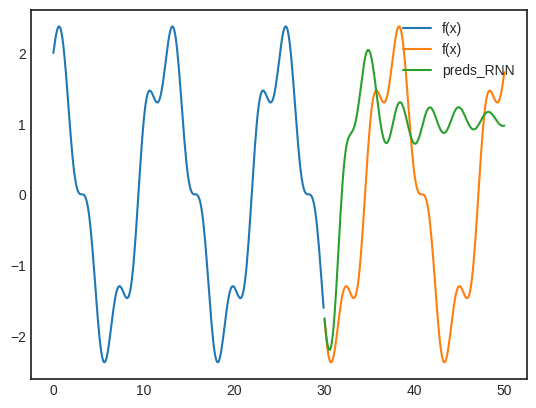

In [47]:

# we clearly see that the RNN is good at predicting in the beginning
# but becomes worse the longer time it takes as we make predictions
# on predictions leading to errors in errors
ax = df_train.plot()
df_test.plot(ax = ax);

### LSTM

LSTM - Long short term memory cell has both a long-term dependency part and a short-term dependency part. In more details it has a **forget gate**, **input gate** and an **output gate** with **weights** to regulate how much information to retain in hidden state and long term memory.

In [48]:
from tensorflow.keras.layers import LSTM

LSTM_layer = LSTM(units = batch_length, return_sequences=False, input_shape=(None,1))

model = RNN_model(LSTM_layer)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0757 - val_loss: 0.0030
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4695e-04 - val_loss: 0.0014
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.8435e-04 - val_loss: 3.4207e-04
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.0958e-04 - val_loss: 1.0640e-04
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9632e-05 - val_loss: 3.3560e-05
Epoch 9/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2529e-05 - val_loss: 2.1418e-05
Epoch 10/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8010e-05 - val_loss: 5.3987e-06


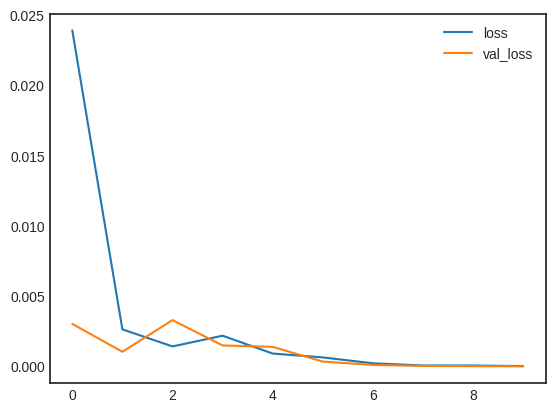

In [50]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot();

In [51]:
predictions = np.zeros([len(scaled_test),1])
first_batch = scaled_train[-batch_length:]
new_batch = first_batch[None, :]

for i, _ in enumerate(df_test.values):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    # role one step forward to build new batch for next prediction
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)
y_pred[:3], df_test.iloc[:3].values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

(array([[-1.74575272],
        [-1.88758732],
        [-2.01202416]]),
 array([[-1.76620533, -1.75413016],
        [-1.91336611, -1.89014344],
        [-2.04466812, -2.00679404]]))

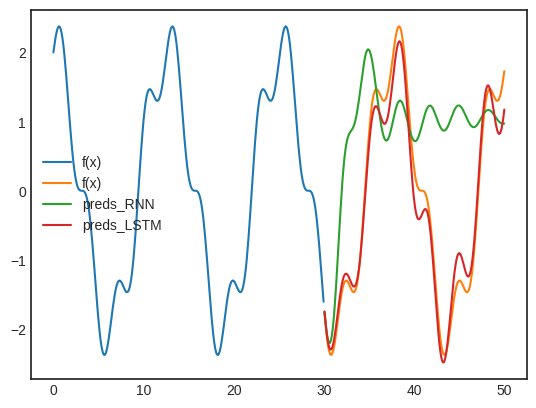

In [52]:
df_test.insert(df_test.shape[1], "preds_LSTM", y_pred)
#df_test["preds_LSTM"] = y_pred
ax = df_train.plot()
df_test.plot(ax = ax);

# probably need longer training here and/or maybe some hidden layer to learn the structures

### Forecasting

Now we will forecast into the future, which we haven't seen yet. This means that there is no way in beforehand to tell how the prediction goes. We will however pick our LSTM model as it seems to have learned the test data well.

In [53]:
scaler = MinMaxScaler()
all_data = scaler.fit_transform(df)
all_data_generator = TimeseriesGenerator(
    all_data, all_data, length=batch_length, batch_size=batch_size
)

LSTM_layer = LSTM(batch_length, return_sequences=False, input_shape=(None, 1))
model = RNN_model(LSTM_layer)

model.fit(all_data_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0330
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0142
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.5245e-04
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2283e-04
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.8686e-05
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.8917e-06
Epoch 8/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2284e-05
Epoch 9/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.4675e-06
Epoch 10/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.7391e-06


In [54]:
steps_in_future = 200

predictions = np.zeros([steps_in_future,1])
first_batch = all_data[-batch_length:]
new_batch = first_batch[None, :]

for i in range(steps_in_future):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    # role one step forward to build new batch for next prediction
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1)

y_pred = scaler.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [55]:

x_future = np.linspace(50.1, 50.1 + steps_in_future * 0.1, num=steps_in_future)
df_forecast = pd.DataFrame(y_pred, columns = ["Forecast"], index=x_future)
df_forecast.head()

,Forecast
50.100000,1.795446
50.200503,1.891798
50.301005,1.978961
50.401508,2.053696
50.502010,2.112742


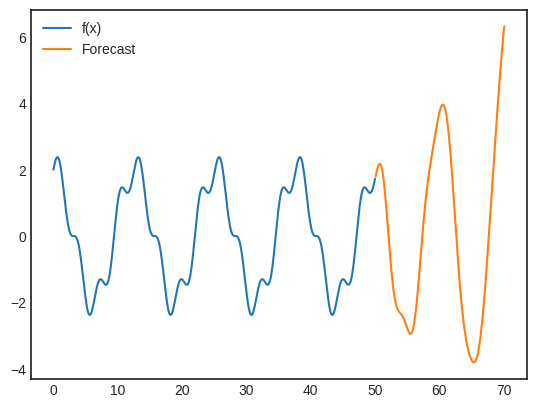

In [56]:
ax = df.plot()
df_forecast.plot(ax = ax);